# fine-mapping

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from matplotlib_venn import venn3, venn3_unweighted
import myvariant
%matplotlib inline

## Data Preprocessing

In [ ]:
# Load the summary statistics
df = pd.read_csv("input/IGAP_stage_1.txt", header=0, sep='\t')

# Add the column of ZScores = Beta / SE
df['Zscore'] = df['Beta'] / df['SE']

# Add the empty column of minor allele frequency
# df['MAF'] = ''

# Reorder the columns
cols = df.columns.tolist()
cols = cols[:3] + [cols[-1]] + cols[3:-1]
df = df[cols]

# Output the dataset in the required form
h = ['CHR', 'BP', 'rsID', 'MAF', 'EA', 'NEA', 'BETA', 'SE', 'P', 'Zscore']
df.to_csv('input/summary.txt', sep='\t', header=h, index=False)

In [54]:
# Load the summary statistics
df = pd.read_csv("input/IGAP_stage_1.txt", header=0, sep='\t')

# Add the column of ZScores = Beta / SE
df['Zscore'] = df['Beta'] / df['SE']

# Add the empty column of minor allele frequency
# df['MAF'] = ''

# Reorder the columns
cols = df.columns.tolist()
cols = cols[:3] + [cols[-1]] + cols[3:-1]
df = df[cols]

# Output the dataset in the required form
h = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'BETA', 'SE', 'P', 'Zscore']
df.to_csv('input/variants.txt', sep='\t', header=h, index=False)

In [1]:
# Input sample sizes
sample_size = 17008 + 37154
sample_size

54162

## Commands used to run the programs

In [ ]:
# %%bash
# # download programs
# cd bin
# ./00_set_up.sh

# # Compute LD and build the reference panel
# cd ../ref
# mkdir ./ld/vcf
# cp /datasets/cs284-sp21-A00-public/1000Genomes/*.gz ./ld/vcf
# cp /datasets/cs284-sp21-A00-public/1000Genomes/*.tbi ./ld/vcf
# nohup python 01_prepare_reference.py &

# # Run fine-mapping tools
# cd ..
# nohup python fine_map_pipe.py -s 54162 input/summary.txt output &
# mv nohup.out def_param_nohup.out
# mv output/summary_total_credible_set.txt output/def_param_tot_cred_set.txt

# # Run fine-mapping tools with diff params
# nohup python fine_map_pipe.py -s 54162 -n 2 input/summary.txt output &
# mv nohup.out n_2_nohup.out
# mv output/summary_total_credible_set.txt output/n_2_tot_cred_set.txt

## Process the results

In [38]:
## Extact the executation time from the nohup outputs
def extract_exec_time(logs):
    ''' Extract the executation time printed in the nohup log file '''
    exec_time = {'PAINTOR': 0, 'CAVIARBF': 0, 'FINEMAP': 0}
    with open(logs, 'r') as infile:
        for line in infile:
            if line.startswith('---'):
                _, prog, _, _, time, _ = line.strip().split()
                exec_time[prog] += int(time[:-1])
    return exec_time

In [7]:
exec_time = extract_exec_time("output/def_param_nohup.out")
print("Execution time: PAINTOR = {} s, CAVIARBF = {} s, FINEMAP = {} s\n".format(*exec_time.values()))

# Use FINEMAP runtime as a reference
print("Relative exec time: PAINTOR = {}, CAVIARBF = {}, FINEMAP = {}".format(*np.array(list(exec_time.values()))/exec_time['FINEMAP']))

Execution time: PAINTOR = 1094 s, CAVIARBF = 810 s, FINEMAP = 335 s

Relative exec time: PAINTOR = 3.265671641791045, CAVIARBF = 2.417910447761194, FINEMAP = 1.0


In [42]:
exec_time2 = extract_exec_time("output/nohup.out")
print("Execution time: PAINTOR = {} s, CAVIARBF = {} s, FINEMAP = {} s\n".format(*exec_time2.values()))
print("Relative exec time: PAINTOR = {}, CAVIARBF = {}, FINEMAP = {}".format(*np.array(list(exec_time2.values()))/exec_time2['FINEMAP']))

Execution time: PAINTOR = 196240 s, CAVIARBF = 2372 s, FINEMAP = 1427 s

Relative exec time: PAINTOR = 137.51927119831814, CAVIARBF = 1.662228451296426, FINEMAP = 1.0


In [208]:
## Load the final results (credible sets)
res = pd.read_csv("output/def_param_tot_cred_set.txt", sep='\t', header=0)
res = res.sort_values(['FINEMAP'], ascending=False)
res.rename(columns={'BP':'POS','EA':'REF','NEA':'ALT'}, inplace=True)
res['cred_set'] = -1
print(res.shape)
res.head(10)

(6684, 16)


,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,-1
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,-1
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,-1
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,-1
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,-1
15,2,127892810,rs6733839,0.3797,T,C,0.1880,0.0176,1.659000e-26,10.681818,0.504097,0.504220,0.504194,207,7,-1
16,2,127891427,rs4663105,0.4036,C,A,0.1837,0.0172,1.001000e-26,10.680233,0.495903,0.495779,0.495806,207,7,-1
6675,19,1063443,rs4147929,0.1849,A,G,0.1348,0.0224,1.701000e-09,-6.017857,0.380885,0.392008,0.389905,1580,7,-1
312,7,143099133,rs10808026,0.2227,A,C,-0.1393,0.0206,1.417000e-11,-6.762136,0.342352,0.348517,0.347266,832,7,-1
326,11,60103385,rs72924659,0.2942,T,C,-0.1413,0.0196,5.354000e-13,-7.209184,0.326261,0.345285,0.341369,1129,7,-1


In [225]:
markers = []
for i in range(blocks.shape[0]):
    chr_, start, stop = blocks.iloc[i]
    # print()
    res_sel = res[(res['CHR'] == chr_) & (res['POS'] >= start) & (res['POS'] <= stop)].sort_values(['FINEMAP'], ascending=False)
    res.loc[(res['CHR'] == chr_) & (res['POS'] >= start) & (res['POS'] <= stop), ['cred_set']] = i+1
    # res_sel
    marker = res_sel.iloc[0]['rsID']
    # print(marker)
    markers.append(marker)

In [226]:
res.head(10)

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,13
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,11
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,9
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,8
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,10
15,2,127892810,rs6733839,0.3797,T,C,0.1880,0.0176,1.659000e-26,10.681818,0.504097,0.504220,0.504194,207,7,2
16,2,127891427,rs4663105,0.4036,C,A,0.1837,0.0172,1.001000e-26,10.680233,0.495903,0.495779,0.495806,207,7,2
6675,19,1063443,rs4147929,0.1849,A,G,0.1348,0.0224,1.701000e-09,-6.017857,0.380885,0.392008,0.389905,1580,7,12
312,7,143099133,rs10808026,0.2227,A,C,-0.1393,0.0206,1.417000e-11,-6.762136,0.342352,0.348517,0.347266,832,7,5
326,11,60103385,rs72924659,0.2942,T,C,-0.1413,0.0196,5.354000e-13,-7.209184,0.326261,0.345285,0.341369,1129,7,7


In [3]:
## load the summary statistics
df = pd.read_csv("input/summary.txt", sep='\t')
df['P'] = df['P'] + 1e-100
df.head(10)

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore
0,1,751343,rs28544273,NaN,A,T,-0.0146,0.0338,0.6651,-0.431953
1,1,751756,rs143225517,NaN,C,T,-0.0146,0.0338,0.6651,-0.431953
2,1,752566,rs3094315,NaN,G,A,-0.0122,0.0294,0.6773,-0.414966
3,1,753405,rs61770173,NaN,C,A,-0.0126,0.0339,0.7104,-0.371681
4,1,768253,rs2977608,NaN,A,C,-0.0394,0.0261,0.1308,-1.509579
5,1,768448,rs77786510,NaN,A,G,-0.0385,0.0303,0.2034,-1.270627
6,1,769963,rs7518545,NaN,A,G,-0.0471,0.0360,0.1904,-1.308333
7,1,845274,rs112856858,NaN,T,G,0.0234,0.0329,0.4766,0.711246
8,1,845635,rs117086422,NaN,T,C,0.0317,0.0303,0.2944,1.046205
9,1,845938,rs57760052,NaN,A,G,0.0307,0.0295,0.2967,1.040678


In [4]:
## load identified causal blocks
blocks = pd.read_csv("output/summary_significant_blocks.txt", sep='\t', header=0)
print(blocks.shape)
blocks

(13, 3)


,chr,start,stop
0,1,206073265,208410364
1,2,127373764,128034347
2,6,31571218,32682664
3,6,47311898,48391125
4,7,142656310,144968289
5,8,26682525,28162392
6,11,58780549,62223771
7,11,84381272,86619301
8,11,121175943,122591910
9,14,91296860,93132299


In [255]:
df.loc[df['P'] <= 1e-30, ['P']] = 1e-30
df['P'].min()

1e-30

In [259]:
# Manhattan plot
# visuz.marker.mhat(df=df, chr='CHR', pv='P', gwas_sign_line=True, gwasp=5e-8, dotsize=1, color=['pink','skyblue'], valpha=0.5,
# ylm=(0,31,2), markernames=markers, markeridcol='rsID', gfont=3)
visuz.marker.mhat(df=df, chr='CHR', pv='P', gwas_sign_line=True, gwasp=5e-8, dotsize=1, color=['pink','skyblue'], valpha=0.5,
ylm=(0,31,2), gfont=3)

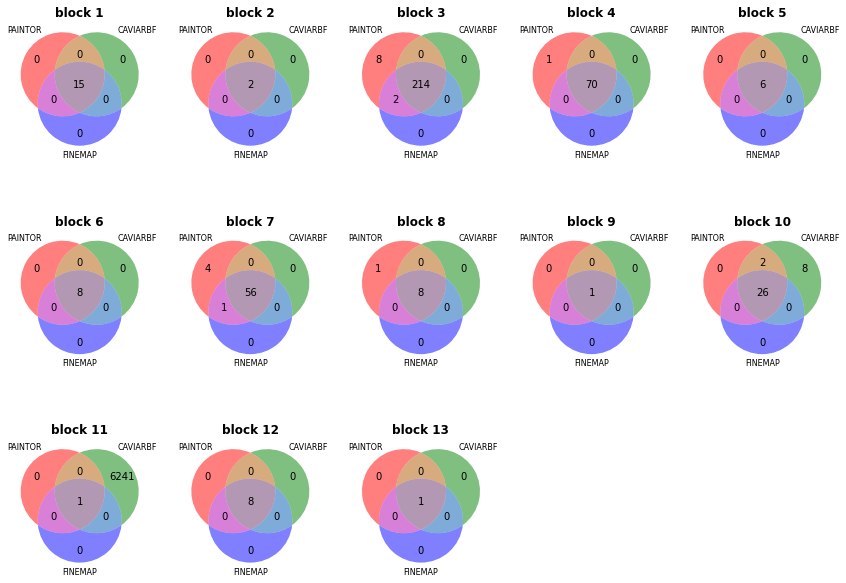

In [206]:
figure, axes = plt.subplots(3, 5, figsize=(12,9))
for i in range(13):
    counts = [res[(res['cred_set'] == i+1) & (res['label'] == j)].shape[0] for j in range(1,8)]
#     vd = venn3(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], ax=axes[int(i/5)][i%5], alpha=0.5)
    vd = venn3_unweighted(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], ax=axes[int(i/5)][i%5], alpha=0.5)
    for set_label in ['A','B','C']:
        vd.get_label_by_id(set_label).set_fontsize(8)
        vd.get_label_by_id(set_label).set_alpha(1)
#         vd.get_label_by_id(set_label).set_fontweight('bold')
#     if i in [2, 6]:
#         vd.get_label_by_id('100').set_y(0.1)
#         vd.get_label_by_id('101').set_y(-0.1)
#         vd.get_label_by_id('111').set_x(0.05)
#     if i == 9:
        
#     if i == 10:
#         vd.get_label_by_id('A').set_y(0.15)
#         vd.get_label_by_id('C').set_y(-0.2)
    axes[int(i/5)][i%5].set_title("block {}".format(i+1), fontweight='bold')
figure.delaxes(axes[2][3])
figure.delaxes(axes[2][4])
# figure.suptitle('Venn diagram of credible sets for each causal block', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("venn_1.png")
plt.show()

In [242]:
def single_venn(res, i, weighted=False, fpath=None):
    counts = [res[(res['cred_set'] == i) & (res['label'] == j)].shape[0] for j in range(1,8)]
    if weighted:
        venn3(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], alpha=0.5)
    else:
        venn3_unweighted(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], alpha=0.5)
    plt.title("block {}".format(i), fontweight='bold')
    if not fpath:
        plt.savefig("images/block{}.png".format(i))
    else:
        plt.savefig(fpath)
    plt.show()

In [266]:
mv = myvariant.MyVariantInfo()

In [358]:
genes[1248]

'MEP1B'

In [360]:
# # Naive search with dbSNP
# # Caution: missing entries need to be verified
# # Note: takes some time to run the following code
# genes, annot = [np.nan]*res.shape[0], [np.nan]*res.shape[0]
# for i in range(res.shape[0]):
#     print(i, res.iloc[i]['rsID'])
#     out = mv.query('dbsnp.rsid:{}'.format(res.iloc[i]['rsID']), fields='dbsnp')
#     if len(out['hits']) == 0: continue
#     if 'gene' not in out['hits'][0]['dbsnp']: continue
#     if type(out['hits'][0]['dbsnp']['gene']) == dict:
#         genes[i] = out['hits'][0]['dbsnp']['gene']['symbol']
#         if type(out['hits'][0]['dbsnp']['gene']['rnas']) == dict:
#             if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas']: continue
#             so = out['hits'][0]['dbsnp']['gene']['rnas']['so']
#             annot[i] = so['name'] if type(so) == dict else so[0]['name']
#         else:
#             if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas'][0]: continue
#             so = out['hits'][0]['dbsnp']['gene']['rnas'][0]['so']
#             annot[i] = so['name'] if type(so) == dict else so[0]['name']
#     else:
#         genes[i] = out['hits'][0]['dbsnp']['gene'][0]['symbol']
#         if type(out['hits'][0]['dbsnp']['gene'][0]['rnas']) == dict:
#             if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas']: continue
#             so = out['hits'][0]['dbsnp']['gene'][0]['rnas']['so']
#             annot[i] = so['name'] if type(so) == dict else so[0]['name']
#         else:
#             if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]: continue
#             so = out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]['so']
#             annot[i] = so['name'] if type(so) == dict else so[0]['name']

In [383]:
res['gene'] = np.array(genes)
res['annotation'] = np.array(annot)
res.head()

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,13,NECTIN2,intron_variant
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,11,DSG2,intron_variant
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,9,SORL1,intron_variant
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,8,nan,nan
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,10,SLC24A4,intron_variant


In [395]:
res.loc[(res['gene'] != 'nan') & (res['annotation'] == 'nan'), ['annotation']] = ['500B Downstream Variant', '2KB Upstream Variant', '500B Downstream Variant', '2KB Upstream Variant', '2KB Upstream Variant']

In [396]:
res[res['rsID'].isin(['rs146645322','rs4799315','rs7230418','rs6506938','rs8096135'])]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
1239,18,29802899,rs146645322,0.0099,T,C,0.1632,0.1134,0.1500,1.439153,1.437140e-06,8.829741e-07,1.022380e-06,1547,2,11,MEP1B,500B Downstream Variant
1354,18,29306415,rs4799315,0.0080,T,C,-0.1343,0.0990,0.1750,-1.356566,1.285240e-06,7.868047e-07,9.116850e-07,1547,2,11,B4GALT6,2KB Upstream Variant
2538,18,28995988,rs7230418,0.4841,C,A,0.0140,0.0161,0.3858,0.869565,7.606510e-07,4.578392e-07,5.323110e-07,1547,2,11,DSG4,500B Downstream Variant
2724,18,29305268,rs6506938,0.4523,T,C,0.0142,0.0175,0.4172,-0.811429,7.255220e-07,4.360286e-07,5.071080e-07,1547,2,11,B4GALT6,2KB Upstream Variant
3962,18,29304880,rs8096135,0.4682,A,G,0.0090,0.0176,0.6090,-0.511364,5.987540e-07,3.576177e-07,4.164320e-07,1547,2,11,B4GALT6,2KB Upstream Variant


In [397]:
# save the updated file
res.to_csv("output/proc_res.txt", sep='\t', index=False)

In [354]:
# out1 = mv.query('dbsnp.rsid:{}'.format('rs146645322'), fields='dbsnp')
# # out

In [398]:
# out1['hits'][0]['dbsnp']['gene']['rnas']

In [399]:
# out1['hits'][0]['dbsnp']['gene']['rnas']

In [409]:
# column names to show
col_shown = res.columns[:-5].tolist() + res.columns[-4:].tolist()
print(col_shown)

['CHR', 'POS', 'rsID', 'MAF', 'REF', 'ALT', 'BETA', 'SE', 'P', 'Zscore', 'PAINTOR', 'CAVIARBF', 'FINEMAP', 'label', 'cred_set', 'gene', 'annotation']


In [410]:
## credible sets
res[res['cred_set'] == 13][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set,gene,annotation
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.0,1.0,1.0,7,13,NECTIN2,intron_variant


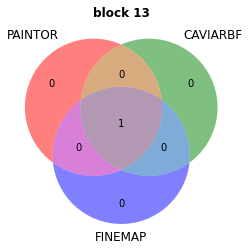

In [237]:
counts = [res[(res['cred_set'] == 13) & (res['label'] == j)].shape[0] for j in range(1,8)]
venn3_unweighted(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], alpha=0.5)
plt.title("block 13", fontweight='bold')
plt.savefig("images/block13.png")
plt.show()

In [228]:
res[(res['cred_set'] == 11)]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,9.894970e-01,9.347876e-01,9.922400e-01,1547,7,11
434,18,27935498,rs3110689,0.1998,T,C,-0.0684,0.0197,5.063000e-04,-3.472081,1.800520e-04,1.292257e-04,1.450230e-04,1547,2,11
435,18,27940854,rs11083394,0.1988,G,A,-0.0686,0.0199,5.546000e-04,-3.447236,1.656820e-04,1.185954e-04,1.331650e-04,1547,2,11
436,18,28333975,rs74354143,0.0785,T,C,0.1004,0.0301,8.415000e-04,3.335548,1.148410e-04,8.124188e-05,9.143930e-05,1547,2,11
437,18,28008295,rs61705963,0.2167,A,C,-0.0628,0.0193,1.141000e-03,-3.253886,8.851740e-05,6.209862e-05,7.001100e-05,1547,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,18,28294595,rs2733126,0.3807,A,G,0.0000,0.0160,9.983000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,1547,2,11
6660,18,28292940,rs1943573,0.3807,G,A,0.0000,0.0160,9.980000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,1547,2,11
6659,18,29682501,rs72940728,0.0905,G,A,0.0000,0.0249,9.991000e-01,0.000000,5.275970e-07,3.138325e-07,3.657450e-07,1547,2,11
6658,18,29680776,rs112923970,0.0944,T,C,-0.0000,0.0249,9.999000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,1547,2,11


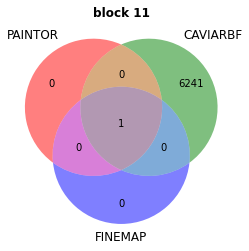

In [413]:
## venn diagram fro block 11
single_venn(res, 11)

In [414]:
res[(res['cred_set'] == 11) & (res['label'] == 7)][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set,gene,annotation
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.99224,7,11,DSG2,intron_variant


In [416]:
res[res['cred_set'] == 11][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set,gene,annotation
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,9.894970e-01,9.347876e-01,9.922400e-01,7,11,DSG2,intron_variant
434,18,27935498,rs3110689,0.1998,T,C,-0.0684,0.0197,5.063000e-04,-3.472081,1.800520e-04,1.292257e-04,1.450230e-04,2,11,LOC105372047,intron_variant
435,18,27940854,rs11083394,0.1988,G,A,-0.0686,0.0199,5.546000e-04,-3.447236,1.656820e-04,1.185954e-04,1.331650e-04,2,11,LOC105372047,intron_variant
436,18,28333975,rs74354143,0.0785,T,C,0.1004,0.0301,8.415000e-04,3.335548,1.148410e-04,8.124188e-05,9.143930e-05,2,11,nan,nan
437,18,28008295,rs61705963,0.2167,A,C,-0.0628,0.0193,1.141000e-03,-3.253886,8.851740e-05,6.209862e-05,7.001100e-05,2,11,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,18,28294595,rs2733126,0.3807,A,G,0.0000,0.0160,9.983000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,2,11,nan,nan
6660,18,28292940,rs1943573,0.3807,G,A,0.0000,0.0160,9.980000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,2,11,nan,nan
6659,18,29682501,rs72940728,0.0905,G,A,0.0000,0.0249,9.991000e-01,0.000000,5.275970e-07,3.138325e-07,3.657450e-07,2,11,RNF138,intron_variant
6658,18,29680776,rs112923970,0.0944,T,C,-0.0000,0.0249,9.999000e-01,-0.000000,5.275970e-07,3.138325e-07,3.657450e-07,2,11,RNF138,intron_variant


In [411]:
res[res['cred_set'] == 9][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set,gene,annotation
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.041,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,7,9,SORL1,intron_variant


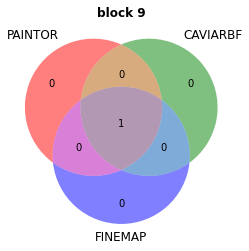

In [412]:
# venn diagram for block 9
single_venn(res, 9)

In [244]:
res[res['cred_set'] == 8][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,7,8
388,11,85868640,rs3851179,0.3708,T,C,-0.1305,0.0165,2.844000e-15,7.909091,0.187362,0.186282,0.186538,7,8
389,11,85856187,rs7110631,0.3161,C,G,-0.1303,0.0168,9.342000e-15,7.755952,0.058697,0.056287,0.056788,7,8
390,11,85831541,rs471470,0.3330,C,A,-0.1273,0.0165,1.189000e-14,7.715152,0.043249,0.041081,0.041528,7,8
391,11,85858538,rs7941541,0.3161,G,A,-0.1284,0.0168,2.200000e-14,7.642857,0.025274,0.023608,0.023948,7,8
392,11,85820077,rs543293,0.3300,A,G,-0.1257,0.0165,2.409000e-14,7.618182,0.021065,0.019564,0.019870,7,8
393,11,85828551,rs474479,0.3181,C,G,-0.1260,0.0166,3.867000e-14,7.590361,0.017165,0.015841,0.016110,7,8
394,11,85830157,rs567075,0.3181,T,C,-0.1258,0.0167,4.273000e-14,7.532934,0.011276,0.010271,0.010473,7,8
395,11,85831246,rs573167,0.3330,G,A,-0.1242,0.0165,5.612000e-14,7.527273,0.010820,0.009843,0.010040,1,8


In [245]:
res[res['cred_set'] == 7][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set
326,11,60103385,rs72924659,0.2942,T,C,-0.1413,0.0196,5.354000e-13,-7.209184,0.326261,0.345285,0.341369,7,7
327,11,60021948,rs1582763,0.3628,A,G,-0.1152,0.0164,2.036000e-12,-7.024390,0.091388,0.092934,0.092639,7,7
328,11,60099225,rs4939338,0.3588,T,C,-0.1153,0.0165,2.602000e-12,6.987879,0.071349,0.071995,0.071881,7,7
329,11,60076940,rs11824773,0.3668,C,G,-0.1107,0.0159,3.720000e-12,-6.962264,0.060021,0.060237,0.060209,7,7
330,11,60076693,rs11824734,0.3628,A,G,-0.1111,0.0160,3.967000e-12,-6.943750,0.052992,0.052975,0.052992,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,11,59986399,rs4492839,0.4006,A,T,-0.1009,0.0158,1.661000e-10,-6.386076,0.001453,0.001297,0.001328,1,7
382,11,59943109,rs2278867,0.4046,T,A,-0.1009,0.0158,1.734000e-10,-6.386076,0.001453,0.001297,0.001328,5,7
383,11,60000574,rs7936120,0.4006,A,T,-0.1009,0.0158,1.719000e-10,-6.386076,0.001453,0.001297,0.001328,1,7
384,11,59996266,rs11601689,0.4006,C,G,-0.1009,0.0158,1.757000e-10,-6.386076,0.001453,0.001297,0.001328,1,7


In [240]:
res[res['cred_set'] == 2][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set
15,2,127892810,rs6733839,0.3797,T,C,0.1880,0.0176,1.659000e-26,10.681818,0.504097,0.504220,0.504194,7,2
16,2,127891427,rs4663105,0.4036,C,A,0.1837,0.0172,1.001000e-26,10.680233,0.495903,0.495779,0.495806,7,2


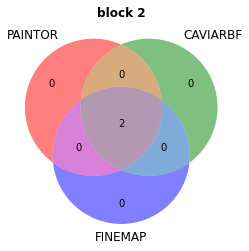

In [243]:
single_venn(res, 2)

In [418]:
## All SNPs here are annotated as "CR1: Intron variant"
res[res['cred_set'] == 1][['CHR','POS','rsID','P','PAINTOR','CAVIARBF','FINEMAP','gene','annotation']]

,CHR,POS,rsID,P,PAINTOR,CAVIARBF,FINEMAP,gene,annotation
0,1,207750568,rs679515,4.105000e-15,0.175250,0.179341,0.178496,CR1,intron_variant
1,1,207738077,rs7515905,3.930000e-15,0.168609,0.172337,0.171568,CR1,intron_variant
2,1,207747296,rs1752684,3.653000e-15,0.167714,0.171394,0.170635,CR1,intron_variant
3,1,207698044,rs6661489,7.613000e-15,0.082756,0.082732,0.082742,CR1,intron_variant
4,1,207692049,rs6656401,7.726000e-15,0.075954,0.075729,0.075780,CR1,intron_variant
5,1,207786828,rs2093760,1.163000e-14,0.056235,0.055545,0.055691,CR1,intron_variant
6,1,207799874,rs10863420,1.850000e-14,0.042207,0.041318,0.041503,CR1,intron_variant
7,1,207685786,rs4266886,2.342000e-14,0.030220,0.029277,0.029472,CR1,intron_variant
8,1,207806730,rs6697005,2.574000e-14,0.027705,0.026768,0.026961,CR1,intron_variant
9,1,207798694,rs10779335,2.645000e-14,0.026641,0.025709,0.025901,CR1,intron_variant


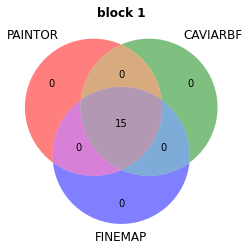

In [252]:
single_venn(res, 1)

In [260]:
res[res['cred_set'] == 1][['PAINTOR','CAVIARBF','FINEMAP']].sum(axis=0)

PAINTOR     0.958655
CAVIARBF    0.961138
FINEMAP     0.960634
dtype: float64

## Results whem max_causal_variant=2

In [43]:
## Load the final results (credible sets)
res2 = pd.read_csv("output/summary_total_credible_set.txt", sep='\t', header=0)
res2 = res2.sort_values(['FINEMAP'], ascending=False)
res2['cred_set'] = -1
print(res2.shape)
res2.head(10)

(109, 16)


,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000e+00,0.000000e+00,1.000000,1609,4,-1
67,11,121451813,rs1790211,0.0159,T,G,-0.3168,0.0606,1.750000e-07,5.227723,8.318840e-06,0.000000e+00,1.000000,1169,4,-1
45,7,143095256,rs35251323,0.3171,G,A,0.0884,0.0184,1.622000e-06,4.804348,9.790850e-12,0.000000e+00,1.000000,832,4,-1
34,6,32565662,rs9270640,0.2922,A,G,-0.0903,0.0222,4.672000e-05,-4.067568,3.905520e-145,0.000000e+00,1.000000,657,4,-1
28,2,127887750,rs62158731,0.2575,T,C,-0.1189,0.0202,4.176000e-09,-5.886139,4.119830e-10,2.347334e-137,1.000000,207,4,-1
62,11,84434573,rs553071,0.2972,T,C,-0.0409,0.0169,1.554000e-02,2.420118,8.429880e-93,0.000000e+00,1.000000,1142,4,-1
74,14,92930445,rs61977311,0.2366,A,G,0.0787,0.0181,1.326000e-05,4.348066,1.279280e-09,0.000000e+00,1.000000,1369,4,-1
107,19,45365604,rs12980613,0.4095,G,A,0.1976,0.0178,1.477000e-28,11.101124,0.000000e+00,1.000000e+00,1.000000,1609,6,-1
29,2,127883899,rs7559175,0.2763,G,A,-0.1138,0.0189,1.613000e-09,6.021164,3.504520e-10,2.011547e-137,0.999936,207,4,-1
41,6,47421188,rs7774615,0.4920,A,G,-0.0747,0.0158,2.161000e-06,4.727848,2.636610e-31,0.000000e+00,0.999900,667,4,-1


In [44]:
markers2 = []
for i in range(blocks.shape[0]):
    chr_, start, stop = blocks.iloc[i]
    # print()
    res2_sel = res2[(res2['CHR'] == chr_) & (res2['BP'] >= start) & (res2['BP'] <= stop)].sort_values(['FINEMAP'], ascending=False)
    res2.loc[(res2['CHR'] == chr_) & (res2['BP'] >= start) & (res2['BP'] <= stop), ['cred_set']] = i
    # res_sel
    marker = res2_sel.iloc[0]['rsID']
    # print(marker)
    markers2.append(marker)

In [46]:
res2[res2['cred_set'] == 12]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000,0.0,1.000000e+00,1609,4,12
107,19,45365604,rs12980613,0.4095,G,A,0.1976,0.0178,1.477000e-28,11.101124,0.000000,1.0,1.000000e+00,1609,6,12
106,19,45361960,rs417193,0.4095,C,T,0.1103,0.0169,7.057000e-11,6.526627,0.000000,1.0,1.066760e-266,1609,2,12
104,19,45395266,rs157580,0.3757,G,A,-0.3779,0.0177,1.210000e-101,21.350282,1.000000,0.0,0.000000e+00,1609,1,12
105,19,45404431,rs741780,0.4483,C,T,-0.4104,0.0171,2.290000e-127,-24.000000,0.996771,0.0,0.000000e+00,1609,1,12


In [47]:
res2[res2['cred_set'] == 11]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
88,19,1050874,rs12151021,0.3380,A,G,0.1131,0.0222,3.392000e-07,-5.094595,0.603013,0.000000e+00,5.484010e-01,1580,5,11
93,19,1043638,rs3752231,0.2654,T,C,0.1188,0.0248,1.716000e-06,4.790323,0.048340,0.000000e+00,4.456210e-01,1580,5,11
89,19,1063443,rs4147929,0.1849,A,G,0.1348,0.0224,1.701000e-09,-6.017857,0.138802,0.000000e+00,2.997530e-01,1580,5,11
99,19,1048393,rs67027268,0.1044,A,G,0.2074,0.0354,4.702000e-09,5.858757,0.004477,0.000000e+00,2.445280e-01,1580,4,11
92,19,1056492,rs3752246,0.1899,G,C,0.1345,0.0229,4.264000e-09,-5.873362,0.056702,0.000000e+00,1.518460e-01,1580,5,11
100,19,1042809,rs3764645,0.4463,G,A,-0.1004,0.0215,2.994000e-06,-4.669767,0.001121,0.000000e+00,1.026070e-01,1580,4,11
101,19,1048051,rs78410552,0.1024,T,G,0.1859,0.0329,1.664000e-08,5.650456,0.001455,0.000000e+00,5.990150e-02,1580,4,11
102,19,1047687,rs4147911,0.1044,G,C,0.1869,0.0328,1.250000e-08,5.698171,0.001890,0.000000e+00,4.297860e-02,1580,4,11
103,19,1047078,rs4147910,0.1044,G,A,0.1863,0.0327,1.261000e-08,5.697248,0.001881,0.000000e+00,4.255530e-02,1580,4,11
91,19,1039323,rs111278892,0.1581,G,C,0.1867,0.0371,4.813000e-07,5.032345,0.074523,0.000000e+00,4.043650e-11,1580,1,11


In [48]:
res2[res2['cred_set'] == 10]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
84,18,27991433,rs3098921,0.2932,G,A,0.0338,0.0175,5.352000e-02,1.931429,1.993690e-51,0.0,9.345400e-01,1547,4,10
85,18,28007034,rs8086175,0.3290,T,C,0.0462,0.0171,6.810000e-03,-2.701754,8.558690e-51,0.0,8.773070e-01,1547,4,10
86,18,28007258,rs1946997,0.3300,C,T,0.0455,0.0171,7.650000e-03,-2.660819,7.767000e-51,0.0,1.218830e-01,1547,4,10
82,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,1.000000e+00,1.0,4.589460e-06,1547,3,10
83,18,29079200,rs73414289,0.0119,G,T,-0.1691,0.1236,1.712000e-01,-1.368123,1.000000e+00,1.0,3.458090e-21,1547,3,10


In [49]:
res2[res2['cred_set'] == 9]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
74,14,92930445,rs61977311,0.2366,A,G,0.0787,0.0181,0.000013,4.348066,1.279280e-09,0.000000,1.000000e+00,1369,4,9
75,14,92931983,rs3993878,0.2296,G,A,0.0781,0.0179,0.000013,-4.363128,1.322020e-09,0.000000,2.256240e-01,1369,4,9
76,14,92932018,rs10129711,0.2296,A,G,0.0780,0.0179,0.000013,-4.357542,1.293080e-09,0.000000,1.710390e-01,1369,4,9
77,14,92931737,rs941648,0.2296,G,A,0.0780,0.0179,0.000013,-4.357542,1.293080e-09,0.000000,1.710390e-01,1369,4,9
78,14,92932051,rs10129728,0.2296,A,G,0.0779,0.0179,0.000013,-4.351955,1.264820e-09,0.000000,1.296840e-01,1369,4,9
79,14,92932485,rs4904923,0.2296,G,C,0.0778,0.0179,0.000014,-4.346369,1.237240e-09,0.000000,9.834710e-02,1369,4,9
80,14,92932479,rs4904922,0.2296,G,T,0.0778,0.0179,0.000014,-4.346369,1.237240e-09,0.000000,9.834710e-02,1369,4,9
81,14,92932575,rs10130373,0.2296,C,A,0.0778,0.0179,0.000014,-4.346369,1.237240e-09,0.000000,9.834710e-02,1369,4,9
69,14,91914643,rs10140477,0.1501,T,C,0.1125,0.0463,0.015200,2.429806,9.918700e-01,0.000000,1.983280e-87,1369,1,9
72,14,91365828,rs114303120,0.0129,T,C,-0.2269,0.1199,0.058420,-1.892410,4.100640e-03,0.747417,1.106160e-87,1369,2,9


In [50]:
res2[res2['cred_set'] == 8]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
67,11,121451813,rs1790211,0.0159,T,G,-0.3168,0.0606,1.750000e-07,5.227723,0.000008,0.0,1.000000e+00,1169,4,8
68,11,121423640,rs7946599,0.0149,A,G,-0.3504,0.0671,1.769000e-07,-5.222057,0.000008,0.0,9.320880e-01,1169,4,8
65,11,121671976,rs1320712,0.1113,A,C,-0.0394,0.0264,1.359000e-01,-1.492424,0.996831,1.0,2.718040e-169,1169,3,8
66,11,121672040,rs1448140,0.1113,A,G,0.0229,0.0338,4.982000e-01,0.677515,0.996830,1.0,7.619520e-170,1169,3,8


In [51]:
res2[res2['cred_set'] == 7]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
62,11,84434573,rs553071,0.2972,T,C,-0.0409,0.0169,0.015540,2.420118,8.429880e-93,0.0,1.000000e+00,1142,4,7
63,11,84408284,rs11234133,0.3082,G,T,-0.0449,0.0167,0.007341,-2.688623,2.129720e-92,0.0,7.324010e-01,1142,4,7
64,11,84408706,rs10898285,0.3082,C,T,-0.0447,0.0168,0.007798,-2.660714,1.945270e-92,0.0,2.675780e-01,1142,4,7
61,11,85494375,rs116468712,0.0288,C,T,0.1983,0.0494,0.000060,4.014170,1.000000e+00,1.0,5.795330e-33,1142,3,7
60,11,85482094,rs76420725,0.0288,T,C,-0.0948,0.0549,0.084390,-1.726776,1.000000e+00,1.0,8.570660e-36,1142,3,7


In [52]:
res2[res2['cred_set'] == 6]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
58,11,60002935,rs718376,0.3936,A,G,-0.1057,0.0162,7.442000e-11,-6.524691,3.844660e-19,0.0,9.960510e-01,1129,4,6
59,11,60039917,rs2162254,0.4016,T,A,-0.1094,0.0160,7.833000e-12,6.837500,2.440760e-18,0.0,9.960510e-01,1129,4,6
56,11,59388596,rs112268927,0.0089,C,G,0.2462,0.0909,6.764000e-03,2.708471,9.999150e-01,1.0,2.194250e-310,1129,3,6
57,11,59494180,rs2447309,0.0089,C,G,-0.0475,0.1210,6.950000e-01,-0.392562,9.999150e-01,1.0,4.479810e-312,1129,3,6


In [53]:
res2[res2['cred_set'] == 5]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
50,8,27463618,rs9331908,0.3509,T,C,0.1120,0.0180,4.697000e-10,6.222222,8.048760e-21,0.000000e+00,9.512600e-01,869,4,5
51,8,27465312,rs11787077,0.3897,T,C,-0.1411,0.0167,2.765000e-17,8.449102,1.497420e-16,0.000000e+00,4.368850e-01,869,4,5
52,8,27462481,rs7982,0.3857,A,G,-0.1400,0.0165,2.477000e-17,8.484848,1.479480e-16,0.000000e+00,2.212570e-01,869,4,5
53,8,27464929,rs4236673,0.3877,A,G,-0.1409,0.0167,2.818000e-17,8.437126,1.286010e-16,0.000000e+00,1.662410e-01,869,4,5
54,8,27466157,rs1532276,0.3887,T,C,-0.1410,0.0168,5.717000e-17,8.392857,8.513710e-17,0.000000e+00,1.083330e-01,869,4,5
55,8,27467821,rs2070926,0.3936,C,G,-0.1455,0.0172,2.656000e-17,8.459302,7.273250e-17,0.000000e+00,4.916060e-02,869,4,5
48,8,26705946,rs36073504,0.0219,A,G,0.3437,0.0954,3.140000e-04,3.602725,6.726220e-01,1.000000e+00,5.868630e-38,869,3,5
49,8,26707408,rs35105547,0.0219,C,T,0.3420,0.0953,3.307000e-04,3.588667,3.273780e-01,8.635411e-11,5.566440e-38,869,1,5
47,8,26685273,rs35869218,0.0219,T,A,0.0186,0.0796,8.147000e-01,0.233668,1.000000e+00,1.000000e+00,5.090620e-41,869,3,5


In [55]:
res2[res2['cred_set'] == 4]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
45,7,143095256,rs35251323,0.3171,G,A,0.0884,0.0184,0.000002,4.804348,9.790850e-12,0.000000,1.000000e+00,832,4,4
46,7,143083839,rs6464548,0.3072,T,C,0.0942,0.0196,0.000002,-4.806122,1.020410e-11,0.000000,9.877670e-01,832,4,4
43,7,144623586,rs59454346,0.3032,A,G,0.0408,0.0235,0.082450,1.736170,5.303100e-01,0.978422,9.485460e-102,832,3,4
44,7,144623591,rs56346401,0.3032,C,G,0.0409,0.0236,0.083080,1.733051,4.694830e-01,0.021578,9.439570e-102,832,1,4
42,7,144623673,rs55961508,0.3032,G,A,-0.0590,0.0684,0.388700,-0.862573,9.999990e-01,1.000000,4.772830e-102,832,3,4


In [56]:
res2[res2['cred_set'] == 3]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
41,6,47421188,rs7774615,0.4920,A,G,-0.0747,0.0158,0.000002,4.727848,2.636610e-31,0.0,9.999000e-01,667,4,3
40,6,47396116,rs2184396,0.4940,G,T,-0.0724,0.0157,0.000004,-4.611465,9.663700e-32,0.0,9.999000e-01,667,4,3
37,6,47518939,rs9367285,0.3111,T,A,0.1755,0.0577,0.002359,3.041594,9.638020e-01,0.0,2.036320e-154,667,1,3
36,6,47578705,rs7757703,0.3072,A,G,-0.0251,0.0162,0.122700,-1.549383,1.000000e+00,0.0,1.674050e-156,667,1,3
39,6,48331245,rs9473314,0.0885,T,C,-0.0534,0.0366,0.145000,-1.459016,2.263550e-20,1.0,7.053000e-157,667,2,3
38,6,48331614,rs9473319,0.0885,C,T,0.0611,0.0571,0.284600,1.070053,2.288590e-20,1.0,4.294390e-157,667,2,3


In [57]:
res2[res2['cred_set'] == 2]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
34,6,32565662,rs9270640,0.2922,A,G,-0.0903,0.0222,4.672000e-05,-4.067568,3.905520e-145,0.000000e+00,1.000000e+00,657,4,2
35,6,32565745,rs9270644,0.2714,G,A,0.1081,0.0215,5.086000e-07,-5.027907,1.380900e-121,0.000000e+00,9.991150e-01,657,4,2
32,6,32580741,rs3997874,0.2654,A,G,0.1139,0.0199,9.484000e-09,-5.723618,8.080180e-77,1.000000e+00,4.515220e-09,657,2,2
33,6,32569164,rs9270786,0.2654,T,C,-0.0170,0.0249,4.947000e-01,-0.682731,1.000820e-76,1.000000e+00,4.823180e-128,657,2,2
30,6,32421010,rs9268790,0.3817,G,A,-0.0583,0.0177,1.006000e-03,-3.293785,1.000000e+00,0.000000e+00,1.984310e-134,657,1,2
31,6,32421329,rs567082101,0.3797,G,T,0.0943,0.0226,3.118000e-05,4.172566,1.000000e+00,7.622352e-231,4.190810e-135,657,1,2


In [58]:
res2[res2['cred_set'] == 1]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
28,2,127887750,rs62158731,0.2575,T,C,-0.1189,0.0202,4.176000e-09,-5.886139,4.119830e-10,2.347334e-137,1.000000e+00,207,4,1
29,2,127883899,rs7559175,0.2763,G,A,-0.1138,0.0189,1.613000e-09,6.021164,3.504520e-10,2.011547e-137,9.999360e-01,207,4,1
23,2,127784950,rs9677441,0.4503,C,G,-0.0705,0.0232,2.346000e-03,-3.038793,9.963400e-01,9.454920e-86,1.420660e-231,207,1,1
24,2,127787275,rs7572041,0.4423,G,A,-0.0178,0.0155,2.492000e-01,1.148387,5.829480e-01,7.046882e-86,1.412990e-234,207,1,1
25,2,127784031,rs56971880,0.4423,A,C,-0.0176,0.0155,2.578000e-01,1.135484,3.667350e-01,2.408020e-86,1.362720e-234,207,1,1
27,2,127431312,rs17741655,0.3300,A,G,-0.0246,0.0236,2.982000e-01,-1.042373,2.283460e-10,1.000000e+00,4.116870e-236,207,2,1
26,2,127430985,rs28387137,0.3300,A,G,0.0043,0.0177,8.093000e-01,0.242938,1.886030e-10,1.000000e+00,3.139030e-236,207,2,1


In [59]:
res2[res2['cred_set'] == 0]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
5,1,207698044,rs6661489,0.1859,T,C,0.1546,0.0199,7.613000e-15,-7.768844,5.487170e-39,0.0,6.379160e-01,107,4,0
6,1,207374139,rs4844577,0.2048,G,A,0.0783,0.0193,5.131000e-05,4.056995,1.105910e-42,0.0,1.890910e-01,107,4,0
7,1,207384068,rs7532422,0.2058,C,T,0.0774,0.0194,6.342000e-05,3.989691,1.056040e-42,0.0,1.375020e-01,107,4,0
8,1,207747296,rs1752684,0.1789,A,G,0.1541,0.0196,3.653000e-15,-7.862245,1.034170e-38,0.0,1.158340e-01,107,4,0
9,1,207685786,rs4266886,0.1899,T,C,0.1542,0.0202,2.342000e-14,-7.633663,2.115160e-39,0.0,8.940570e-02,107,4,0
10,1,207401680,rs6683677,0.2048,C,G,0.0731,0.0187,9.550000e-05,3.909091,9.884070e-43,0.0,8.015450e-02,107,4,0
11,1,207395031,rs6540875,0.2048,T,C,0.0744,0.0188,7.715000e-05,3.957447,1.023600e-42,0.0,7.252930e-02,107,4,0
12,1,207390204,rs6673080,0.2058,T,C,0.0754,0.0193,9.485000e-05,3.906736,9.950510e-43,0.0,6.174750e-02,107,4,0
14,1,207408969,rs61821051,0.2038,G,C,0.0732,0.0187,9.321000e-05,3.914439,9.854320e-43,0.0,6.082150e-02,107,4,0
13,1,207408598,rs61821050,0.2038,A,C,0.0732,0.0187,9.303000e-05,3.914439,9.854320e-43,0.0,6.082150e-02,107,4,0


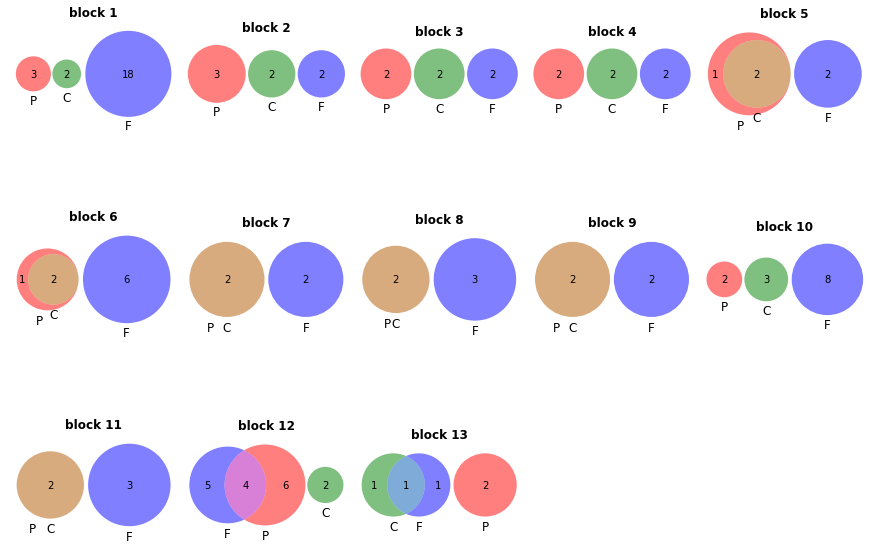

In [205]:
figure, axes = plt.subplots(3, 5, figsize=(12,9))
for i in range(13):
    counts = [res2[(res2['cred_set'] == i) & (res2['label'] == j)].shape[0] for j in range(1,8)]
    vd = venn3(subsets=counts, set_labels=['P','C','F'], ax=axes[int(i/5)][i%5], alpha=0.5)
    if i == 4: vd.get_label_by_id('A').set_x(-0.35)
    if i == 5: vd.get_label_by_id('A').set_x(-0.55)
    if i in [6,7,8]: vd.get_label_by_id('A').set_x(-0.45)
    if i == 10: vd.get_label_by_id('A').set_x(-0.55)
    axes[int(i/5)][i%5].set_title("block {}".format(i+1), fontweight='bold')
figure.delaxes(axes[2][3])
figure.delaxes(axes[2][4])
# figure.suptitle('Venn diagram of credible sets for each causal block', fontsize=16, fontweight='bold')
plt.tight_layout(pad=0)
plt.savefig("venn_2.png")
plt.show()